In [180]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder



In [181]:
def get_data(filename):
    df = pd.read_csv(filename, names = ['all'])
    df['all'] = df['all'].str.strip()
    df['all1']  = df['all'].apply(lambda x: np.array(x.split(' ')))
    df[['target','attr1','attr2','attr3','attr4','attr5','attr6','id']] = pd.DataFrame(df.all1.tolist(), index= df.index)
    return df.drop(columns=['all','all1'])

In [182]:
df = get_data(r"\Users\s512fj-ej021t\OneDrive\Desktop\ML\monks-1.train")
df_test = get_data(r"\Users\s512fj-ej021t\OneDrive\Desktop\ML\monks-1.test")

In [183]:
X_train, y_train = df.drop(columns=['target','id']), df['target'].apply(lambda x: int(x))
X_test, y_test = df_test.drop(columns=['target','id']), df_test['target'].apply(lambda x: int(x))

In [184]:
ohe = OneHotEncoder()
ohe.fit(X_train, y_train)
X_train = ohe.transform(X_train).toarray()
X_test = ohe.transform(X_test).toarray()

In [185]:
X_train = X_train.T
y_train = y_train.T

In [186]:
#linear activation function 
def linear(x):
    return x

def d_linear(x):
    return 1

#sigmoid activation function
def sigmoid(x):
    return 1/(1+np.exp(-x))

def d_sigmoid(x):
    f =sigmoid(x)
    return f * (1-f)

#ReLu activation function
def relu(x):
    if x > 0: return x
    else: return 0

def d_relu(x):
    if x > 0: return 1
    else: return 0

def MSE(layer, target):
    return (layer - target)/target.shape[1]

#def binary_crossentropy(layer, target):
#    return (layer - target)/(layer*(1-layer)*target.shape[1])

def binary_crossentropy(y_pred, y_true):
    """
    Calcola la derivata della binary crossentropy rispetto ai valori predetti.

    Parameters:
    - y_true: Valori veri (etichette reali).
    - y_pred: Valori predetti (output del modello).


    Returns:
    - La derivata della binary crossentropy rispetto ai valori predetti.
    """
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Calcolo della derivata rispetto a y_pred
    derivative = - (y_true / y_pred - (1 - y_true) / (1 - y_pred))

    return derivative / len(y_true)  # Media su tutti gli esempi di addestramento 
    

#hyperbolic tangent activation function
def TanH(x):
    return np.tanh(x)

def d_TanH(x):
    return 1 - np.tanh(x)**2 


'''def softmax(hidden_layer):
    s = np.exp(hidden_layer)/np.exp(hidden_layer).sum
    return s '''


def softmax(x):
    """
    Calcola la funzione Softmax per un array di input.

    Parameters:
    - x: Un array di input.

    Returns:
    - Un array con valori Softmax normalizzati.
    """
    exp_x = np.exp(x - np.max(x))  # Evita l'overflow sottraendo il massimo valore
    return exp_x / exp_x.sum(axis=0, keepdims=True)

#def d_softmax(x):
#    return x*(x-1)


def d_softmax(x):
    """
    Calcola la derivata della funzione Softmax rispetto agli elementi di input.

    Parameters:
    - x: Un array di input.

    Returns:
    - Un array con i valori della derivata Softmax.
    """
    softmax_output = softmax(x)
    return softmax_output * (1 - softmax_output)

'''def binary_crossentropy(x):
    d_bce = - 1/(softmax(x))
    return d_bce '''


#Dictionary for the activation functions
act_func = {
    'lin': linear,
    'sigm': sigmoid,
    'relu': relu,
    'tanh': TanH,
    'softmax' : softmax
}

#A second dictionary for their derivatives
d_act_func = {
    'lin': d_linear,
    'sigm': d_sigmoid,
    'relu': d_relu,
    'tanh': d_TanH,
    'softmax': d_softmax
}





In [187]:
class Layer:

    def __init__(self, input, prev_layer, dim_layer, act_function, target):

        self.dim_layer = dim_layer
        self.prev_layer = prev_layer
        self.act_function = np.vectorize(act_func[act_function])
        self.d_act_function = np.vectorize(d_act_func[act_function])
        self.target = target

        if self.prev_layer != None:
            self.dim_batch = self.prev_layer.dim_batch
            self.W = np.random.uniform(-0.5, 0.5, (self.dim_layer, self.prev_layer.dim_layer))    #inizializzo la matrice dei pesi
            self.b = np.random.uniform(-0.5, 0.5, (self.dim_layer, 1))      #inizializzo il vettore dei bias
            self.layer = np.empty((self.dim_layer, self.dim_batch))
        else: 
            self.layer = input
            self.dim_batch = input.shape[1]

    def forward(self):
        if self.prev_layer == None:
            #print('prev_layer == None: return self.layer')
            #print(self.layer.shape)
            return self.layer
        else: 
            #print('prev_layer =! None: compute forward')
            #print(f'W = {self.W}')
            #print(f'b = {self.b}')
            self.z = self.W.dot(self.prev_layer.forward()) + self.b
            self.layer = self.act_function(self.z)
            #print(f'layer = {self.layer}')
            return self.layer
        


    def backward(self, next_delta = None, next_weights = None):
        #print(f'Entered backward: target = {self.target}')
        
        if self.target is None:
            if self.prev_layer != None:
                #print('self.target == None: hidden')
                delta = self.d_act_function(self.z) * next_weights.T.dot(next_delta)
                #self.prev_layer.backward(delta,self.weights)
                self.d_W = delta.dot(self.prev_layer.backward(delta,self.W).T)
                self.d_b = delta.sum(axis=1).reshape((delta.shape[0],1))
                return self.layer

            else: 
                #print('input')
                return self.layer
            
        else:
            #print('self.target != None: output')
            delta = self.d_act_function(self.z) * binary_crossentropy(self.layer, self.target)
            #self.prev_layer.backward(delta,self.weights)
            self.d_W = delta.dot(self.prev_layer.backward(delta,self.W).T)
            self.d_b = delta.sum(axis=1).reshape((delta.shape[0],1))
            return self.layer    

    def update_weights(self, eta, lam):
        if self.prev_layer is None:
            return
        else:  
            self.W = self.W - eta * self.d_W - lam * self.W
            self.prev_layer.update_weights(eta, lam)

    def err(self):
        return np.sqrt((self.layer-self.target)**2).mean()
        #return np.sqrt((self.layer[0]-self.target[0])**2+(self.layer[1]-self.target[1])**2+(self.layer[2]-self.target[2])**2).mean()
    
    #def rel_err(self):
        #return np.sqrt((self.layer[0]-self.target[0])**2/self.target[0]**2+(self.layer[1]-self.target[1])**2/self.target[1]**2+(self.layer[2]
                                                                                                                                
    def err_i(self,i):
        return np.sqrt((self.layer[i]-self.target[i])**2).mean()
    
    def rel_err_i(self,i):
        return (np.sqrt((self.layer[i]-self.target[i])**2)/self.target[i]).mean()
    

In [188]:
y_train = y_train.to_numpy().reshape((1,124))

In [189]:
#np.array(y_train).reshape((2,124)
eta = 0.01
lam = 0.01
o = 0
E1 = []
E2 = []
E3 = []
E = []
dim_batch = 100
input_layer = Layer(X_train, None, 17, 'lin', None)
hidden_layer = Layer(None, input_layer, 5, 'tanh', None)
print(y_train.shape)
output_layer = Layer(None, hidden_layer, 2, 'sigm', np.array(y_train) )
while o<1000:
    
    output_layer.forward()
    #print(output_layer.layer)
    output_layer.backward()
    output_layer.update_weights(eta, lam)
    if o % 10 == 0: print(o)


    E.append(output_layer.err())
    o += 1
    

(1, 124)
0
10
20
30
40
50
60
70


80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


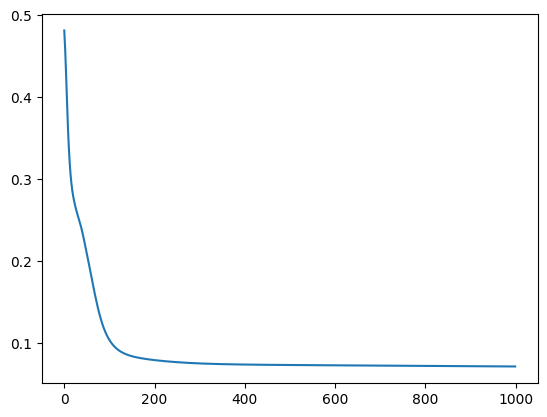

In [190]:
y_train =  [y_train, -(y_train-1)]

np.array(y_train).reshape((2,124))

plt.plot(E)